## ECoG+STN-LFP analysis: demo 

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import mne
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle 
import sys
# from Utilities folder
sys.path.insert(1, './Utilities/icn_m1')
import os
sys.path.insert(1, './Utilities/')
from ML_models import get_model

from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
# define settings
settings = {}
settings['data_path'] = 'Data/'
settings['num_patients'] = ['000'] # for this example we only use one subject
# subfolders indicates the session in this dataset
settings['subfolders']=[['ses-right']]  # this subject only has one session
settings['frequencyranges'] = [[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 3, 3, 3, 3, 10, 10] # this is for the band-power feature extraction


In [3]:
# define some experiments and model parameters
laterality = ["CON", "IPS"]
modality = ["STN", "ECOG", 'COMB']

cv = KFold(n_splits=5, shuffle=False)
spoc_ecog= SPoC(n_components=1, log=None, reg='oas', transform_into ='csp_space', rank='full')
spoc_stn= SPoC(n_components=1, log=None, reg='oas', transform_into ='csp_space', rank='full')
USED_MODEL = 3 # 3 == GLM with alpha 0.5

seglengths = np.asarray(settings['seglengths'])
seglengths = (1000.0/seglengths).astype(int)

### Load the data from both modalities.
This data was already pre-processed, following these steps:
1. Epochs of 1000 ms were extracted.
2. Band-passed filtered epoched data at 8 frequency bands ([4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200])
3. The target variable was downsampled accordinly by taking every 100 samples.

If you want to run this code with your own data, please be sure of arranging your data in a 4d array as follows:
(epochs, channels, samples, frequency bands)

In [4]:
# declare saving variable
score_ecog = OrderedDict()
Coef_ecog = OrderedDict()

score_stn = OrderedDict()
Coef_stn = OrderedDict()

score_comb = OrderedDict()
Coef_comb = OrderedDict()         

In [5]:
# get data
s = 0 # when working with all subjects, this is a for
subfolders=settings["subfolders"][s]
ss = 0 # when working with all subjects, this is a for, since there are subjects which have more than one session.
X_ECOG = [] # to append data
X_STN =[] 
Y_con = []
Y_ips = []
list_of_files_ecog = os.listdir(settings['data_path']+'ECOG') # list of files in the current directory
list_of_files_stn = os.listdir(settings['data_path']+'STN') 

file_name_ = 'ECOG_epochs_sub_' + settings['num_patients'][s] + '_sess_'+subfolders[ss][4:]

file_ecog = [each_file for each_file in list_of_files_ecog if each_file.startswith(file_name_)]
file_name_='STN_epochs_sub_' + settings['num_patients'][s] + '_sess_'+subfolders[ss][4:]

# only load data from runs in which both modalities exit
file_stn= [each_file for each_file in list_of_files_stn if each_file.startswith(file_name_)]
idx_file = [f for f in file_stn if list(set() & set(file_ecog))]
matching_stn = [f for f in file_stn if any(f[4:] in xs for xs in file_ecog)]
matching_ecog = [f for f in file_ecog if any(f[4:] in xs for xs in file_stn)]

if len(matching_ecog) != len(matching_stn):
    raise('Error loading data')

for e in range(len(matching_ecog)):
    with open(settings['data_path'] +'ECOG/' + matching_ecog[e], 'rb') as handle:
        sub_ = pickle.load(handle)    
        data = sub_['epochs']
        X_ECOG.append(data)
        label_ips = sub_['label_ips']
        label_con = sub_['label_con']
        Y_con.append(label_con)
        Y_ips.append(label_ips)
    with open(settings['data_path'] +'STN/' + matching_stn[e], 'rb') as handle:
        sub_ = pickle.load(handle)
        data = sub_['epochs']
        X_STN.append(data)           

X_ECOG = np.concatenate(X_ECOG, axis=0)
X_STN = np.concatenate(X_STN, axis=0)
Y_con = np.concatenate(Y_con, axis=0)
Y_ips = np.concatenate(Y_ips, axis=0)  

Run the experiment!
(and be patient, it takes a time!)

In [6]:
for l, mov in enumerate(laterality):
    print("Training %s" %mov)
    
    score_ecog[mov] = []
    Coef_ecog[mov] = []
    
    score_stn[mov] = []
    Coef_stn[mov] = []
    
    score_comb[mov] = []
    Coef_comb[mov] = []

    if l==0:
        label=Y_con
    else:
        label=Y_ips


    X_ECOG=X_ECOG.astype('float64')
    X_STN=X_STN.astype('float64')

    for train_index, test_index in cv.split(label):
        Ztr, Zte = label[train_index], label[test_index]
        Xtr_ecog, Xte_ecog = X_ECOG[train_index], X_ECOG[test_index]
        Xtr_stn, Xte_stn = X_STN[train_index], X_STN[test_index]
        
        datecog_tr = []
        datecog_te = []
        datstn_tr = []
        datstn_te = []
        filters_stn = []
        patterns_stn = []
        filters_ecog = []
        patterns_ecog = []
        
        
        # features are learned from each modality and then, if combined, concatenated
        # per each frequency band:
        for fb in range(len(settings['frequencyranges'])):
            Gtr_ecog, Gtr_stn = np.squeeze(spoc_ecog.fit_transform(Xtr_ecog[:,:,:,fb], Ztr)), np.squeeze(spoc_stn.fit_transform(Xtr_stn[:,:,:,fb], Ztr))
            Gte_ecog, Gte_stn = np.squeeze(spoc_ecog.transform(Xte_ecog[:,:, :, fb])), np.squeeze(spoc_stn.transform(Xte_stn[:,:, :, fb]))

            filters_ecog.append(spoc_ecog.filters_)
            filters_stn.append(spoc_stn.filters_)

            patterns_ecog.append(spoc_ecog.patterns_)
            patterns_stn.append(spoc_stn.patterns_)

            # define aux var from where the band-power will be calculated
            Aux_ecog, Aux_stn  = Gtr_ecog[:,-seglengths[fb]:], Gtr_stn[:,-seglengths[fb]:]
            Auxte_ecog, Auxte_stn  = Gte_ecog[:,-seglengths[fb]:], Gte_stn[:,-seglengths[fb]:]

            datecog_tr.append(np.log((Aux_ecog ** 2).mean(axis=-1)))
            datecog_te.append(np.log((Auxte_ecog ** 2).mean(axis=-1)))
            datstn_tr.append(np.log((Aux_stn ** 2).mean(axis=-1)))
            datstn_te.append(np.log((Auxte_stn ** 2).mean(axis=-1)))
        
        for m, mod in enumerate(modality):
            print("For brain recording: %s" %mod)
            
            if mod == 'ECOG':
                dat_tr, dat_te = np.vstack(datecog_tr).T, np.vstack(datecog_te).T
            elif mod == 'STN':
                dat_tr, dat_te = np.vstack(datstn_tr).T, np.vstack(datstn_te).T
            else:
                dat_tr = np.vstack((datecog_tr,datstn_tr)).T
                dat_te = np.vstack((datecog_te,datstn_te)).T

            # get the model
            clf, optimizer = get_model(USED_MODEL, x=dat_tr, y=Ztr, distri = 'softplus')
    
            scaler = StandardScaler()
            scaler.fit(dat_tr)
            dat_tr = scaler.transform(dat_tr)
            dat_te = scaler.transform(dat_te)
            
            # fit the model
            clf.fit(dat_tr, Ztr)
            
            # predict
            r2_te = r2_score(Zte, clf.predict(dat_te))
            if r2_te < 0: r2_te = 0

            if mod=='ECOG':
                score_ecog[mov].append(r2_te)
                Coef_ecog[mov].append(clf.beta_)
            elif mod == 'STN':
                score_stn[mov].append(r2_te)
                Coef_stn[mov].append(clf.beta_)

            else:
                score_comb[mov].append(r2_te)
                Coef_comb[mov].append(clf.beta_)

    
        del Xtr_ecog, Xte_ecog, Xtr_stn, Xte_stn

training CON
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
training IPS
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB
For brain recording: STN
For brain recording: ECOG
For brain recording: COMB


### Let's visualize the results

Text(0.5, 0, '')

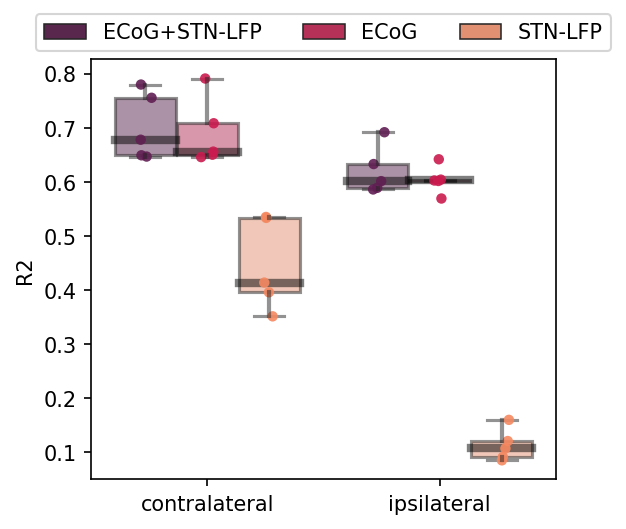

In [7]:
#plot comparative results
import pandas as pd
import seaborn as sb
nam_lat=['contralateral', 'ipsilateral']
df = pd.DataFrame()
for l, lat in enumerate(laterality):
    data = np.vstack((score_comb[lat], score_ecog[lat], score_stn[lat]))
    df_all=pd.DataFrame(data=data.T, columns=[ "ECoG+STN-LFP", "ECoG", "STN-LFP"])
    
    df_all = df_all.stack().reset_index()
    df_all = df_all.rename(columns={'level_0': 'folds',
                                                        'level_1': 'Method',
                                                    0:'R2'})    
    
    df_all["lat"] = nam_lat[l]
    df=pd.concat([df, df_all])      
    
alpha_box = 0.5


plt.figure(figsize=(4,4), dpi=150)
plt.subplots_adjust(bottom=0.18)
sb.boxplot(x="lat", y="R2", hue="Method",  
            data=df, palette="rocket", 
            showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
            showfliers=False, notch=False,
            whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
            capprops={"alpha":alpha_box},
            medianprops=dict(linestyle='-', linewidth=4, color="black", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="R2", hue="Method",  
              data=df,palette="rocket", dodge=True, s=5, alpha=0.9)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(0, 1.02, 1, 0.5), loc=8, borderaxespad=0., ncol=3)
ax.set_xlabel('')

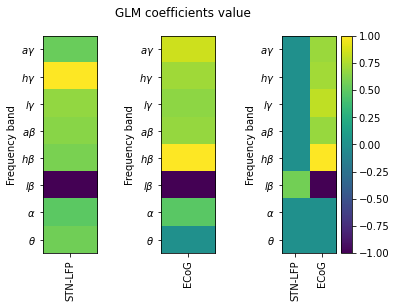

In [8]:
# plot coefficients
def scale(X, a,b):
    X_norm=X.copy()
    nom = X[X!=0]-np.min(X)
    denom = np.max(X) - np.min(X)
    X_norm[X!=0]=(b-a)*(nom/denom) + a
    return X_norm

fig, ax = plt.subplots(1,3)
fig.suptitle('GLM coefficients value')
# we plot here contralateral coeff
for i, mod in enumerate(modality):
    if mod=='ECOG':
        coefs = Coef_ecog['CON']
    elif mod == 'STN':
        coefs = Coef_stn['CON']
    else:
        coefs = Coef_comb['CON']
    # here we show the mean coefficient value across foldings
    coef=np.mean(coefs,axis=0)
    # transformation needed to better interpretation of the results
    coef=(-1)*(np.exp(coef)- np.ones((len(coef))))

    coef=coef.reshape(8, -1, order='F')
    coef=scale(coef, -1,1)
    sp=ax[i].imshow(coef,extent=[0,2, 0, 8])
    ax[i].invert_xaxis()
    ax[i].set_yticks(np.arange(0.5, 8.5, 1));
    ax[i].set_yticklabels([r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$']);
    ax[i].set_ylabel('Frequency band')
    if i==2: fig.colorbar(sp)
    if mod=='ECOG':
        ax[i].set_xticks([1]);
        ax[i].set_xticklabels(['ECoG'], rotation='vertical');
    elif mod == 'STN':
        ax[i].set_xticks([1]);
        ax[i].set_xticklabels(['STN-LFP'], rotation='vertical');
    else:
        ax[i].set_xticks([0.5 , 1.5]);
        ax[i].set_xticklabels(['ECoG', 'STN-LFP'], rotation='vertical');